In [10]:
import os

In [11]:
# Define paths for dataset and augmented dataset (Change to your folder paths in Google Drive)
dataset_path = 'Dataset'  # Path to your uploaded dataset
augmented_dataset_path = 'augmented_dataset'

In [12]:
# Check if the dataset exists
if not os.path.exists(dataset_path):
    print(f"Error: Dataset directory not found at {dataset_path}")
else:
    print(f"Dataset found at {dataset_path}")

Dataset found at Dataset


In [13]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [14]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def augment_dataset(dataset_dir, augmented_dir):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Create augmented dataset directories
    os.makedirs(augmented_dir, exist_ok=True)
    for plastic_type in os.listdir(dataset_dir):
        plastic_type_path = os.path.join(dataset_dir, plastic_type)
        if os.path.isdir(plastic_type_path):  # Ensure it's a directory
            os.makedirs(os.path.join(augmented_dir, plastic_type), exist_ok=True)

            for img_file in os.listdir(plastic_type_path):
                img_path = os.path.join(plastic_type_path, img_file)
                try:
                    img = load_img(img_path, target_size=(224, 224))  # Resize to model input size
                    img_array = img_to_array(img)
                    img_array = img_array.reshape((1,) + img_array.shape)
                    counter = 0
                    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=os.path.join(augmented_dir, plastic_type), save_prefix=plastic_type, save_format="jpg"):
                        counter += 1
                        if counter >= 10:  # Generate 10 augmented images per original
                            break
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

    print("Augmentation complete.")

# Set the correct paths
dataset_path = "Dataset"  # Make sure this is the directory containing image folders
augmented_dataset_path = "augmented_dataset"

# Call the augmentation function
augment_dataset(dataset_path, augmented_dataset_path)


Error processing Dataset\HDPE\image197.avif: cannot identify image file <_io.BytesIO object at 0x000001927ED29530>
Error processing Dataset\LDPE\image115.avif: cannot identify image file <_io.BytesIO object at 0x000001927EA3F7E0>
Error processing Dataset\PET\image140.avif: cannot identify image file <_io.BytesIO object at 0x000001927EA10270>
Error processing Dataset\PP\mountain-discarded-plastic-garbage-bottles-generative-ai_170984-12661 (1).avif: cannot identify image file <_io.BytesIO object at 0x000001927EE94720>
Error processing Dataset\PP\mountain-discarded-plastic-garbage-bottles-generative-ai_170984-12661.avif: cannot identify image file <_io.BytesIO object at 0x000001927EE94720>
Error processing Dataset\PS\CHAPTER-I INTRODUCTION TO DB CONCEPTS.pdf: cannot identify image file <_io.BytesIO object at 0x000001927EE57AB0>
Error processing Dataset\PVC\image74.avif: cannot identify image file <_io.BytesIO object at 0x000001927EE56980>
Error processing Dataset\PVC\image77.avif: cannot 

In [15]:
# Prepare data generators for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2  # 80% training, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 7704 images belonging to 6 classes.
Found 1923 images belonging to 6 classes.


In [16]:
# Build ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [19]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

c:\Users\Aishwarya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.4311 - loss: 1.6147 - val_accuracy: 0.7469 - val_loss: 0.7576
Epoch 2/10
  1/240 ━━━━━━━━━━━━━━━━━━━━ 4:34 1s/step - accuracy: 0.6250 - loss: 1.0497

c:\Users\Aishwarya\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 1.0497 - val_accuracy: 1.0000 - val_loss: 0.1867
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.7343 - loss: 0.7438 - val_accuracy: 0.8557 - val_loss: 0.5195
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.6875 - loss: 0.7095 - val_accuracy: 0.6667 - val_loss: 1.1609
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.8211 - loss: 0.5240 - val_accuracy: 0.8901 - val_loss: 0.3922
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.8125 - loss: 0.4455 - val_accuracy: 1.0000 - val_loss: 0.3282
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.8808 - loss: 0.3774 - val_accuracy: 0.9286 - val_loss: 0.2916
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.8438 - loss: 0.4852 - val_accuracy: 1.0000 - val_loss: 0.1351
Epoch 9/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.9261 - loss: 0.2746 - val_accuracy: 0.9

In [20]:
# Save the trained model
model.save("plastic_classification_resnet50.h5")
print("Model saved as 'plastic_classification_resnet50.h5' in Google Drive.")

Model saved as 'plastic_classification_resnet50.h5' in Google Drive.


In [21]:
# Evaluate the model
val_generator.reset()
predictions = model.predict(val_generator)
predicted_classes = predictions.argmax(axis=-1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

61/61 ━━━━━━━━━━━━━━━━━━━━ 56s 903ms/step


In [22]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))



Confusion Matrix:
[[ 98  86 115  85  56  54]
 [ 66  35  61  32  20  31]
 [103  58 118  75  42  62]
 [ 83  30  79  40  32  24]
 [ 51  31  44  29  28  29]
 [ 60  30  49  37  26  24]]


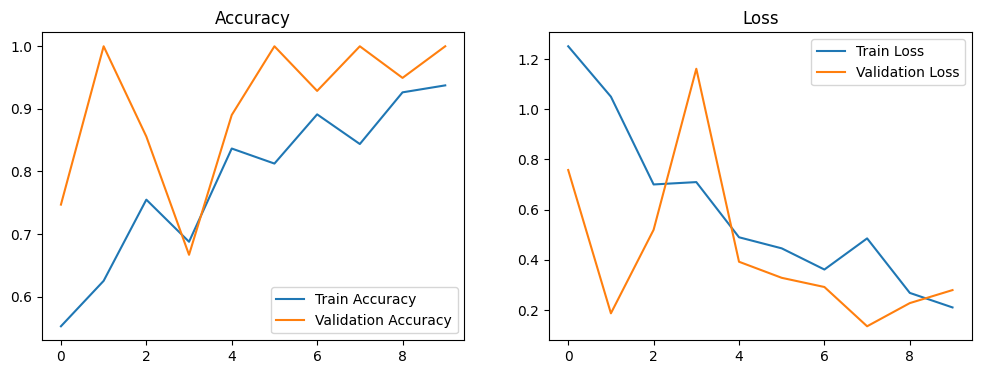

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [24]:
from tensorflow.keras.applications import VGG16


In [ ]:
# Build VGG16 model
epochs = 10  # You can change this value based on your training needs

base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x_vgg16 = base_model_vgg16.output
x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
x_vgg16 = Dense(512, activation="relu")(x_vgg16)
x_vgg16 = Dropout(0.5)(x_vgg16)
predictions_vgg16 = Dense(len(train_generator.class_indices), activation="softmax")(x_vgg16)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

# Freeze the base model layers for VGG16
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Compile the VGG16 model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
# Train the VGG16 model
# Train the model
history = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)



Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.3004 - loss: 4.5068 - val_accuracy: 0.5901 - val_loss: 1.2780
Epoch 2/10
  1/240 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - accuracy: 0.4062 - loss: 2.2440

c:\Users\Aishwarya\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 912us/step - accuracy: 0.4062 - loss: 2.2440 - val_accuracy: 0.6667 - val_loss: 0.3392
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 812s 3s/step - accuracy: 0.4922 - loss: 1.9506 - val_accuracy: 0.6932 - val_loss: 0.9059
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7500 - loss: 0.7879 - val_accuracy: 1.0000 - val_loss: 0.3215
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 6315s 26s/step - accuracy: 0.5828 - loss: 1.2797 - val_accuracy: 0.7406 - val_loss: 0.7300
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4375 - loss: 1.2045 - val_accuracy: 1.0000 - val_loss: 0.2380
Epoch 7/10
 71/240 ━━━━━━━━━━━━━━━━━━━━ 6:39 2s/step - accuracy: 0.6500 - loss: 0.9977

In [ ]:

# Save the trained VGG16 model
model_vgg16.save("plastic_classification_vgg16.h5")
print("VGG16 Model saved as 'plastic_classification_vgg16.h5'.")





VGG16 Model saved as 'plastic_classification_vgg16.h5'.


In [ ]:
# Evaluate the VGG16 model
val_generator.reset()
predictions_vgg16 = model_vgg16.predict(val_generator)
predicted_classes_vgg16 = predictions_vgg16.argmax(axis=-1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step


In [ ]:
# Confusion matrix for VGG16
print("VGG16 Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes_vgg16))



VGG16 Confusion Matrix:
[[214 112 190 136 100 104]
 [113  50 115  58  59  67]
 [196 104 203 115  92 103]
 [131  62 131  76  62  68]
 [108  53  98  53  47  45]
 [121  55  95  63  48  40]]


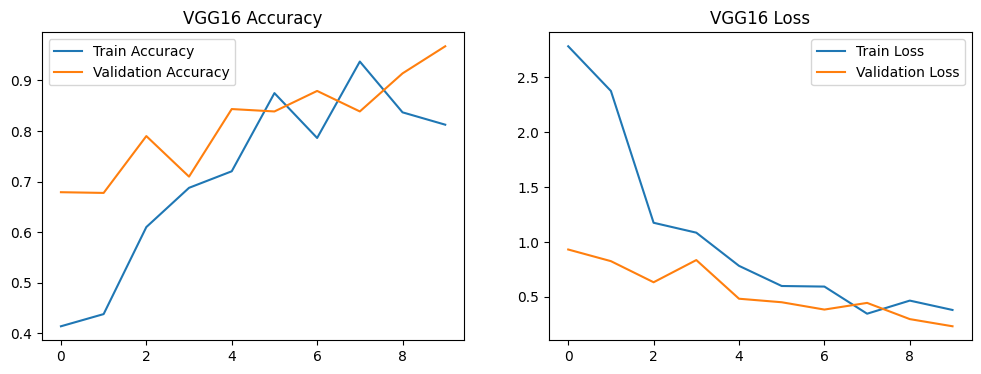

In [ ]:
# Plot training history for VGG16
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("VGG16 Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("VGG16 Loss")
plt.show()

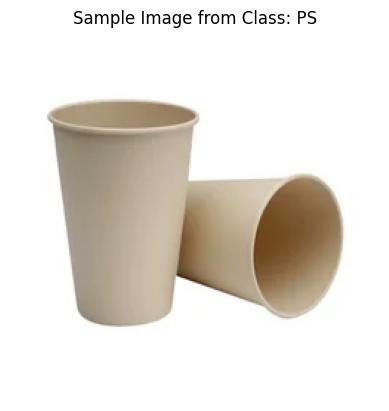

Sample image path: /content/drive/MyDrive/Dataset/PS/image14.webp


In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = 'Dataset'

# Get the class folders in the dataset
class_folders = os.listdir(dataset_path)

# Choose a random class
random_class = random.choice(class_folders)

# Get the images in the chosen class folder
class_folder_path = os.path.join(dataset_path, random_class)
image_files = os.listdir(class_folder_path)

# Choose a random image from the class folder
random_image_file = random.choice(image_files)
image_path = os.path.join(class_folder_path, random_image_file)

# Load the image
image = load_img(image_path)

# Display the image
plt.imshow(image)
plt.title(f"Sample Image from Class: {random_class}")
plt.axis('off')  # Hide axis
plt.show()

print(f"Sample image path: {image_path}")
